# Supervised Learning Capstone Project

## Exploring Wage Disparities Across Occupations

Is there a wage gap? 

The short answer is yes. (slide here of wage ratio)


In this notebook I will be exploring the Kaggle dataset of the US Bureau of Labor Statistics January 2015 report on income by gender and occupation. The dataset states that it shows 535 different occupations, and their corresponding weekly median incomes, broken down into men, women, and all, columns. Also included are reported numbers of emplyees for each occupation. 

### A few things to note before we get started. 



 maybe some kind of talking here. or something

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from sklearn import ensemble
from sklearn.model_selection import cross_val_score, train_test_split
%matplotlib inline

In [2]:
import os
curr_directory = os.getcwd()
datafile = curr_directory + "/inc_occ_gender.csv"
print(datafile)

/Users/Beba/Documents/JupyterNotebooks/CapstoneProject/inc_occ_gender.csv


## Inputing data, preliminary explore and data cleaning

One of the things I found when I began exploring this dataset is that it is quite small. 

    - Uncleaned


Uncleaned, it is 558 rows and 5 columns. Once cleaned of all rows that had any nan values, the row count dropped to 142. During the preliminary exploration, I found that more than half of the occupations did NOT have any input for female wages. 

In [3]:
genderwage = pd.read_csv(datafile)
genderwage.head()

,Occupation,All_workers,All_weekly,M_workers,M_weekly,F_workers,F_weekly
0,ALL OCCUPATIONS,109080,809,60746,895,48334,726
1,MANAGEMENT,12480,1351,7332,1486,5147,1139
2,Chief executives,1046,2041,763,2251,283,1836
3,General and operations managers,823,1260,621,1347,202,1002
4,Legislators,8,Na,5,Na,4,Na


In [4]:
genderwage.describe()

,All_workers,M_workers,F_workers
count,558.000000,558.000000,558.000000
mean,586.458781,326.593190,259.831541
std,4758.979138,2654.600532,2142.551053
min,0.000000,0.000000,0.000000
25%,21.000000,11.000000,3.000000
50%,67.000000,33.500000,18.000000
75%,253.000000,121.750000,84.000000
max,109080.000000,60746.000000,48334.000000


In [5]:
genderwage.dtypes

Occupation     object
All_workers     int64
All_weekly     object
M_workers       int64
M_weekly       object
F_workers       int64
F_weekly       object
dtype: object

In [6]:
genderwage[['All_weekly',
            'M_weekly',
            'F_weekly']] = genderwage[['All_weekly',
                                       'M_weekly',
                                       'F_weekly']].apply(pd.to_numeric, errors='coerce')

In [7]:
genderwage.dtypes

Occupation      object
All_workers      int64
All_weekly     float64
M_workers        int64
M_weekly       float64
F_workers        int64
F_weekly       float64
dtype: object

In [8]:
genderwage.isnull().sum()

Occupation       0
All_workers      0
All_weekly     236
M_workers        0
M_weekly       326
F_workers        0
F_weekly       366
dtype: int64

Converting all rows to numeric format allows us to find

In [9]:
categories = [] 
for i in genderwage['Occupation']:
    if i.isupper()==True:
        categories.append(i)

In [10]:
categories_df = genderwage.loc[genderwage['Occupation'].isin(categories)].reset_index(drop=True)


In [11]:
indices =[]
category_index = pd.Index(list(genderwage['Occupation']))
for i in categories:
    index = category_index.get_loc(i)
    indices.append(index)

In [12]:
genderwage.insert(1, 'Occupation_Category', 0)

In [13]:
cat_count = -1
index_copy = pd.Index(list(genderwage['Occupation']))
for x in genderwage['Occupation']:
    current_index = index_copy.get_loc(x)
    genderwage.iloc[current_index, genderwage.columns.get_loc('Occupation_Category')] = cat_count
    if x.isupper():
        cat_count = cat_count + 1
        genderwage.iloc[current_index, genderwage.columns.get_loc('Occupation_Category')] = cat_count
    

In [14]:
genderwage.insert(1, 'Occupation_Category_label', 0)

In [15]:
cat_label = 'nothing'
for x in genderwage['Occupation']:
    current_index = index_copy.get_loc(x)
    genderwage.iloc[current_index, genderwage.columns.get_loc('Occupation_Category_label')] = cat_label
    if x.isupper():
        cat_label = x
        genderwage.iloc[current_index, genderwage.columns.get_loc('Occupation_Category_label')] = cat_label
    

In [16]:
genderwage.drop([0], inplace=True)

In [17]:
no_wage_df = genderwage.where(genderwage['F_weekly'].isnull())
no_wage_df.head(5) 

,Occupation,Occupation_Category_label,Occupation_Category,All_workers,All_weekly,M_workers,M_weekly,F_workers,F_weekly
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Legislators,MANAGEMENT,1.0,8.0,NaN,5.0,NaN,4.0,NaN
5,Advertising and promotions managers,MANAGEMENT,1.0,55.0,1050.0,29.0,NaN,26.0,NaN


In [18]:
no_wage_df.isnull().sum()

Occupation                   191
Occupation_Category_label    191
Occupation_Category          191
All_workers                  191
All_weekly                   427
M_workers                    191
M_weekly                     467
F_workers                    191
F_weekly                     557
dtype: int64

In [19]:
no_wage_df = no_wage_df.dropna(axis=0, how='all')
no_wage_df.isnull().sum()

Occupation                     0
Occupation_Category_label      0
Occupation_Category            0
All_workers                    0
All_weekly                   236
M_workers                      0
M_weekly                     276
F_workers                      0
F_weekly                     366
dtype: int64

In [20]:
no_wage_df['GenderRatio'] = no_wage_df['F_workers'] / no_wage_df['M_workers']

In [21]:
no_wage_df.describe()

,Occupation_Category,All_workers,All_weekly,M_workers,M_weekly,F_workers,F_weekly,GenderRatio
count,366.000000,366.000000,130.000000,366.000000,90.000000,366.000000,0.0,359.000000
mean,14.688525,69.699454,953.753846,58.896175,979.266667,10.795082,NaN,inf
std,6.951198,128.537814,355.417258,124.705396,376.822874,12.813908,NaN,NaN
min,1.000000,0.000000,354.000000,0.000000,389.000000,0.000000,NaN,0.000000
25%,9.000000,11.000000,685.500000,7.000000,725.250000,1.000000,NaN,0.030769
50%,18.000000,30.000000,874.500000,20.000000,879.500000,5.000000,NaN,0.200000
75%,21.000000,67.000000,1152.500000,49.000000,1103.250000,17.000000,NaN,0.825758
max,22.000000,1181.000000,1952.000000,1155.000000,1892.000000,49.000000,NaN,inf


In [22]:
cleanedgenderwage = genderwage.dropna(axis=0, how='any')

In [23]:
cleanedgenderwage.describe()

,Occupation_Category,All_workers,All_weekly,M_workers,M_weekly,F_workers,F_weekly
count,141.000000,141.000000,141.000000,141.000000,141.000000,141.000000,141.000000
mean,10.765957,1306.815603,921.893617,699.609929,1018.404255,607.156028,828.191489
std,7.010847,2167.067487,369.864834,1249.475306,413.308083,1208.675735,324.080103
min,1.000000,108.000000,391.000000,53.000000,401.000000,50.000000,380.000000
25%,3.000000,253.000000,619.000000,108.000000,674.000000,107.000000,566.000000
50%,12.000000,529.000000,901.000000,278.000000,1001.000000,201.000000,780.000000
75%,17.000000,1287.000000,1165.000000,618.000000,1345.000000,549.000000,1025.000000
max,22.000000,13894.000000,2041.000000,7332.000000,2251.000000,9933.000000,1836.000000


In [24]:
cleanedgenderwage.head()

,Occupation,Occupation_Category_label,Occupation_Category,All_workers,All_weekly,M_workers,M_weekly,F_workers,F_weekly
1,MANAGEMENT,MANAGEMENT,1,12480,1351.0,7332,1486.0,5147,1139.0
2,Chief executives,MANAGEMENT,1,1046,2041.0,763,2251.0,283,1836.0
3,General and operations managers,MANAGEMENT,1,823,1260.0,621,1347.0,202,1002.0
6,Marketing and sales managers,MANAGEMENT,1,948,1462.0,570,1603.0,378,1258.0
8,Administrative services managers,MANAGEMENT,1,170,1191.0,96,1451.0,73,981.0


## Preliminary Data Exploration

Looking at distribution plots for our current features

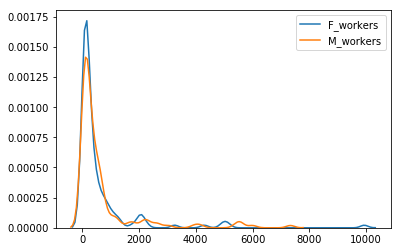

In [25]:
sns.kdeplot(data=cleanedgenderwage['F_workers'])
sns.kdeplot(data=cleanedgenderwage['M_workers'])
plt.show()

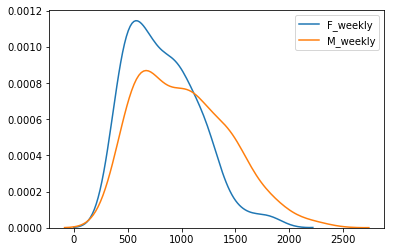

In [26]:
sns.kdeplot(data=cleanedgenderwage['F_weekly'])
sns.kdeplot(data=cleanedgenderwage['M_weekly'])
plt.show()

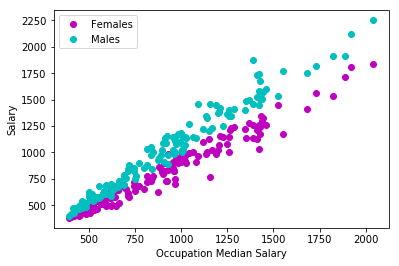

In [27]:
# look at female wages vs male wages on a scatter plot
plt.plot(cleanedgenderwage['All_weekly'], cleanedgenderwage['F_weekly'], 'o', color='m')
plt.plot(cleanedgenderwage['All_weekly'], cleanedgenderwage['M_weekly'], 'o', color='c')
plt.xlabel('Occupation Median Salary')
plt.legend(['Females','Males'])
plt.ylabel('Salary')
plt.show()

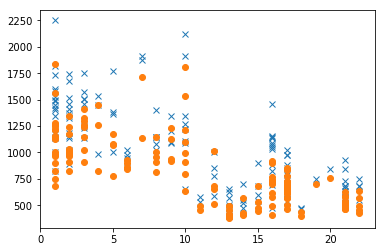

In [28]:
plt.plot(cleanedgenderwage['Occupation_Category'], cleanedgenderwage['M_weekly'], 'x')
plt.plot(cleanedgenderwage['Occupation_Category'], cleanedgenderwage['F_weekly'], 'o')
plt.show()

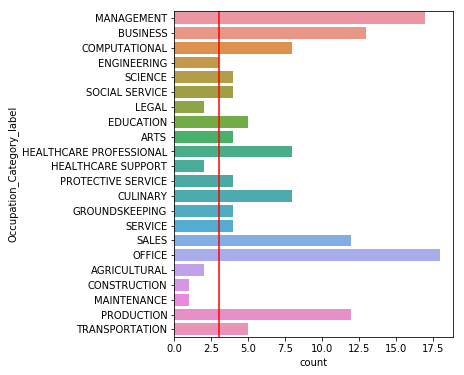

In [29]:
plt.figure(figsize=(5, 6))
sns.countplot(y=cleanedgenderwage['Occupation_Category_label'],
              data=cleanedgenderwage)
plt.axvline(x=3, color='red', linestyle='solid') # 3 is the number of neighbors needed later
plt.show()

In [30]:
# combine categories 
cleanedgenderwage.loc[cleanedgenderwage['Occupation_Category_label'] == 'LEGAL', 'Occupation_Category_label'] = 'SOCIAL SERVICE'
cleanedgenderwage.loc[cleanedgenderwage['Occupation_Category_label'] == 'HEALTHCARE SUPPORT', 'Occupation_Category_label'] = 'HEALTHCARE PROFESSIONAL'
cleanedgenderwage.loc[cleanedgenderwage['Occupation_Category_label'] == 'AGRICULTURAL', 'Occupation_Category_label'] = 'INFRASTRUCTURE SUPPORT'
cleanedgenderwage.loc[cleanedgenderwage['Occupation_Category_label'] == 'CONSTRUCTION', 'Occupation_Category_label'] = 'INFRASTRUCTURE SUPPORT'
cleanedgenderwage.loc[cleanedgenderwage['Occupation_Category_label'] == 'MAINTENANCE', 'Occupation_Category_label'] = 'INFRASTRUCTURE SUPPORT'


/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


## Now lets create some features

Woo!

In [31]:
# see weekly female wage as ratio to mens wage
cleanedgenderwage['WageGap_as_Ratio'] = cleanedgenderwage['F_weekly'] / cleanedgenderwage['M_weekly']

# see ratio of women to men
cleanedgenderwage['GenderRatio'] = cleanedgenderwage['F_workers'] / cleanedgenderwage['M_workers']

# check for count difference between All workers and M+F workers
cleanedgenderwage['All_Workers_Difference'] = cleanedgenderwage['All_workers'] - (cleanedgenderwage['M_workers'] + cleanedgenderwage['F_workers'])

# see female share of workers and complentary male share
cleanedgenderwage['F_share'] = cleanedgenderwage['F_workers'] / cleanedgenderwage['All_workers']
cleanedgenderwage['M_share'] = cleanedgenderwage['M_workers'] / cleanedgenderwage['All_workers']

/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stab

In [32]:
def male_dom(x):
    if x > .85:
        return 0
    return 1

cleanedgenderwage['Male_Dominated'] = cleanedgenderwage['GenderRatio'].apply(male_dom)

/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [33]:
# a significant wage gap is 15% difference or more between womens wages compared to mens

cleanedgenderwage['Significant_wage_gap'] = np.where(cleanedgenderwage['WageGap_as_Ratio'] > .85, 0, 1)

/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [55]:
# same features, just in the categories dataframe
categories_df[['All_weekly',
            'M_weekly',
            'F_weekly']] = categories_df[['All_weekly',
                                       'M_weekly',
                                       'F_weekly']].apply(pd.to_numeric, errors='coerce')

categories_df['WageRatio'] = categories_df['F_weekly'] / categories_df['M_weekly']
categories_df['GenderRatio'] = categories_df['F_workers'] / categories_df['M_workers']
categories_df['WageGap'] = categories_df['M_weekly'] - categories_df['F_weekly']
categories_df['F_share'] = categories_df['F_workers'] / categories_df['All_workers']
categories_df['M_share'] = categories_df['M_workers'] / categories_df['All_workers']
categories_df['All_Workers_Difference'] = categories_df['All_workers'] - (categories_df['M_workers'] + categories_df['F_workers'])




## Lets plot some of these new features
Looking at bar plots of weekly income by occupation, wage gap by occupation, gender ratio by occupation, wage ratio by occupation, and a scatter plot of mens weekly income and womens weekly income as a function of the reported occupation median income.

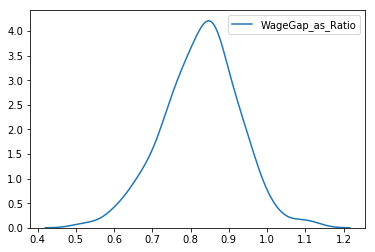

In [35]:
sns.kdeplot(data=cleanedgenderwage['WageGap_as_Ratio'])

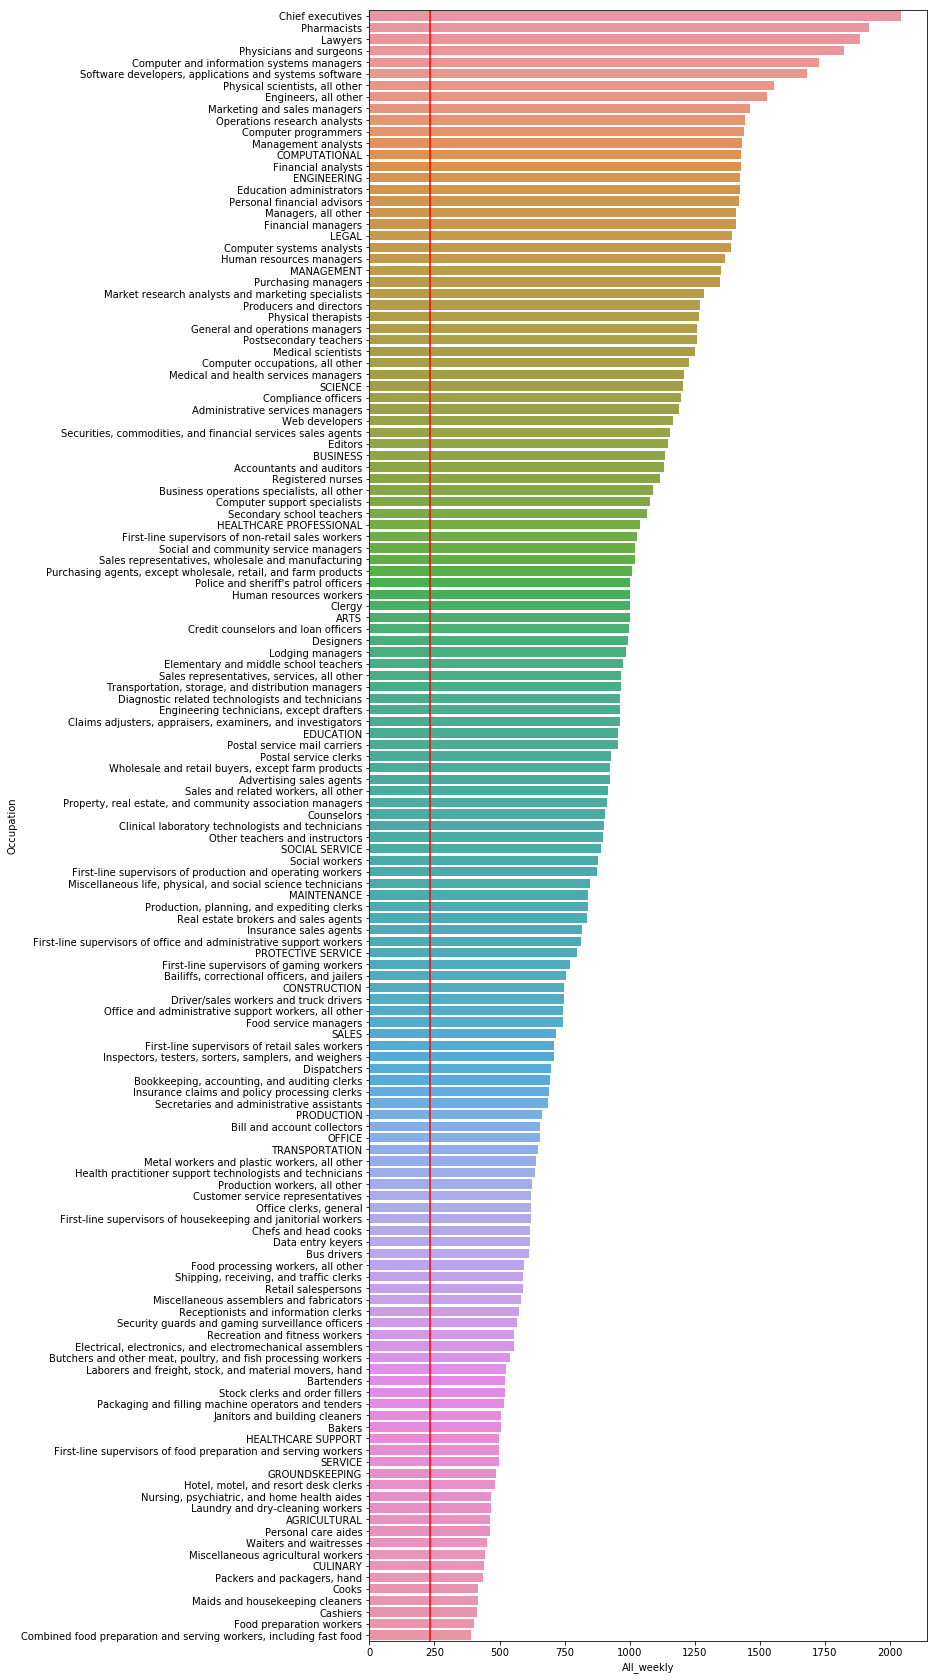

In [57]:
plt.figure(figsize=((10,30)))
sns.barplot(x='All_weekly',
            y='Occupation',
            data=cleanedgenderwage.sort_values('All_weekly', ascending=False))
# HHS defines poverty as $12,140 per year for one person
# That roughly divides into $233 per week(not accounting for taxes)
plt.axvline(x=233, color='red', linestyle='solid')
plt.show()

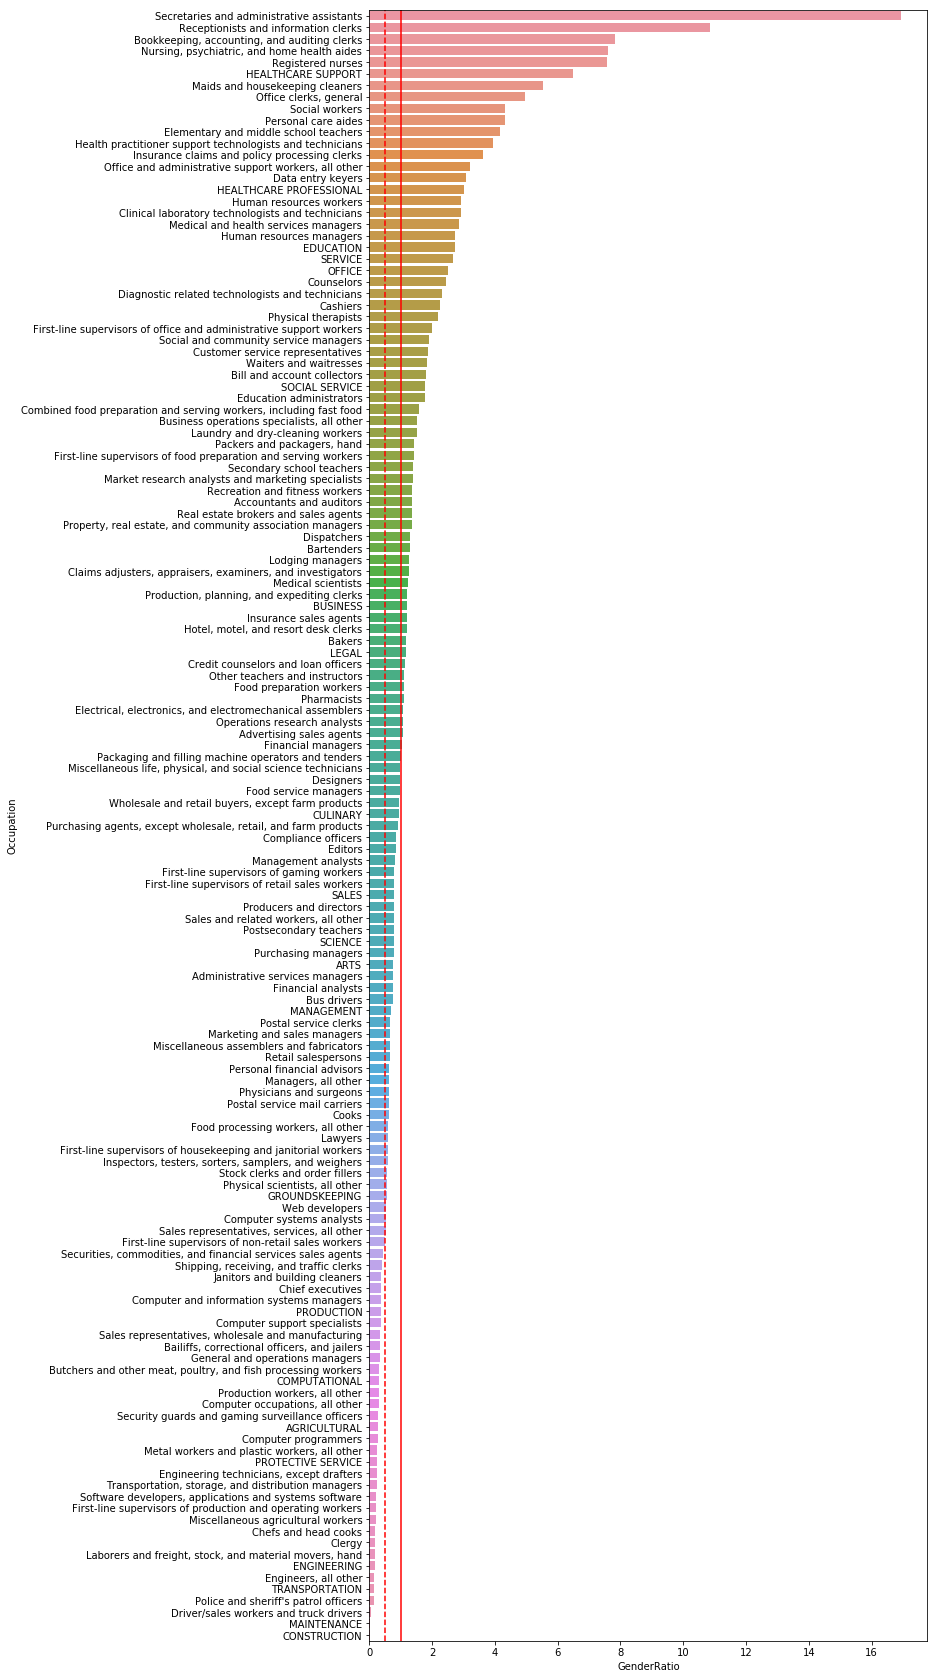

In [37]:
# Now lets look at the ratio of workers
plt.figure(figsize=((10,30)))
sns.barplot(x='GenderRatio',
            y='Occupation',
            data=cleanedgenderwage.sort_values('GenderRatio', ascending=False))
plt.axvline(x=1, color='red', linestyle='solid')
plt.axvline(x=.5, color='red', linestyle='--')
plt.show()

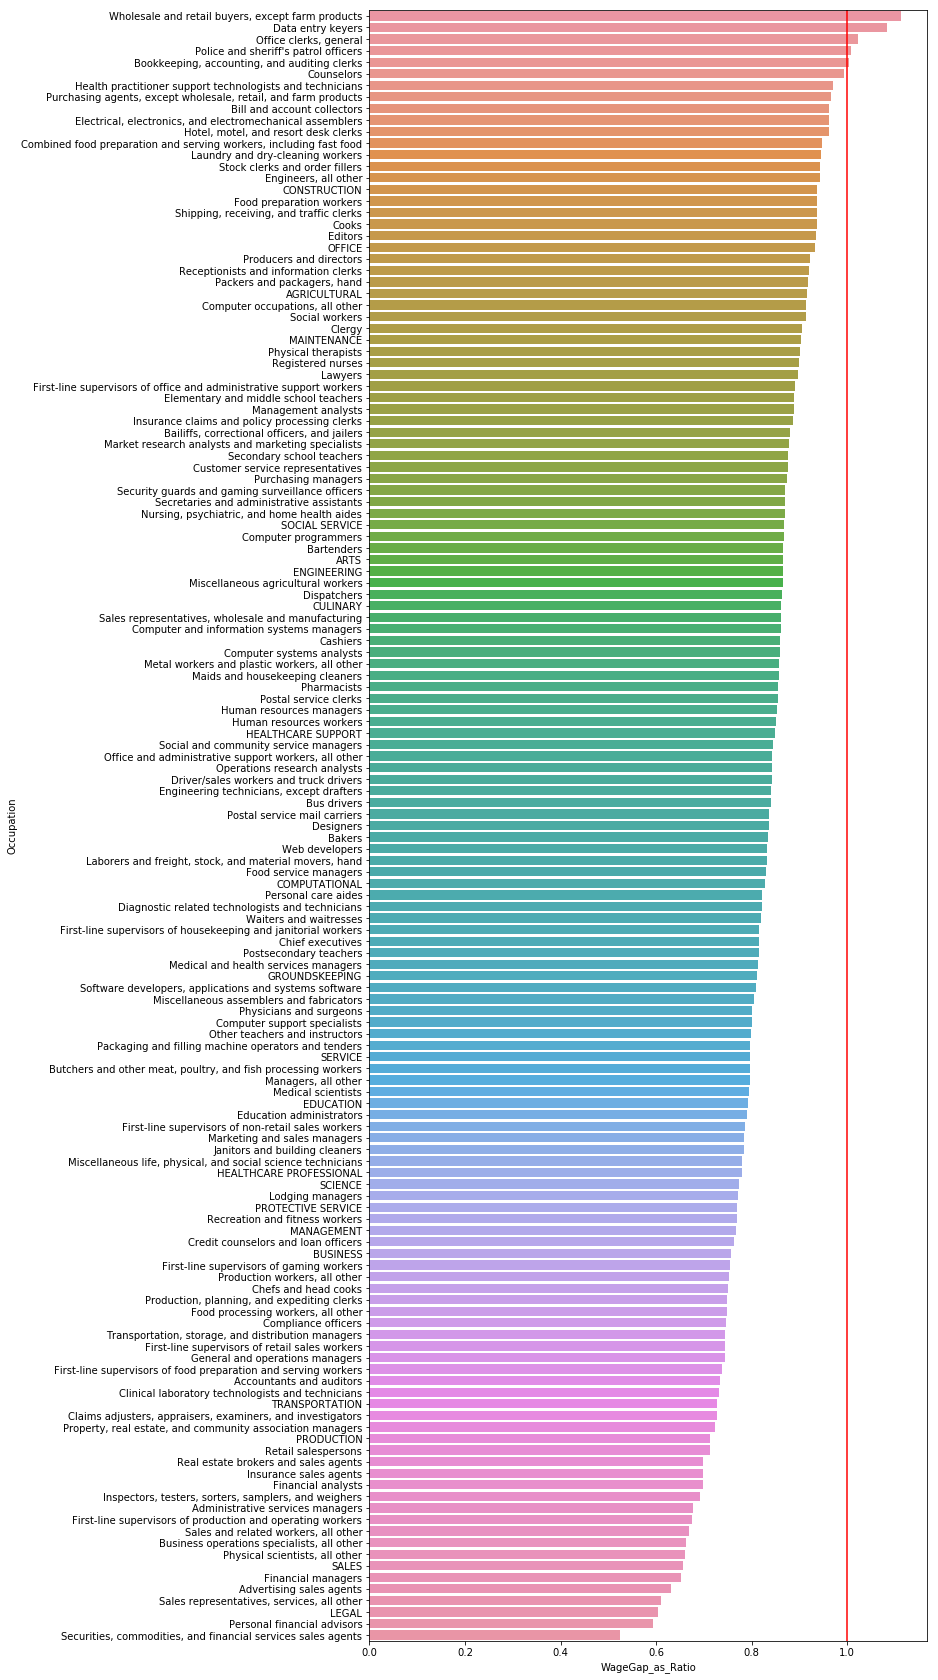

In [63]:
# Look at wage ratio by occupation
plt.figure(figsize=((10,30)))
sns.barplot(x='WageGap_as_Ratio',
            y='Occupation',
            data=cleanedgenderwage.sort_values('WageGap_as_Ratio', ascending=False))
plt.axvline(x=1, color='red', linestyle='solid')
plt.show()

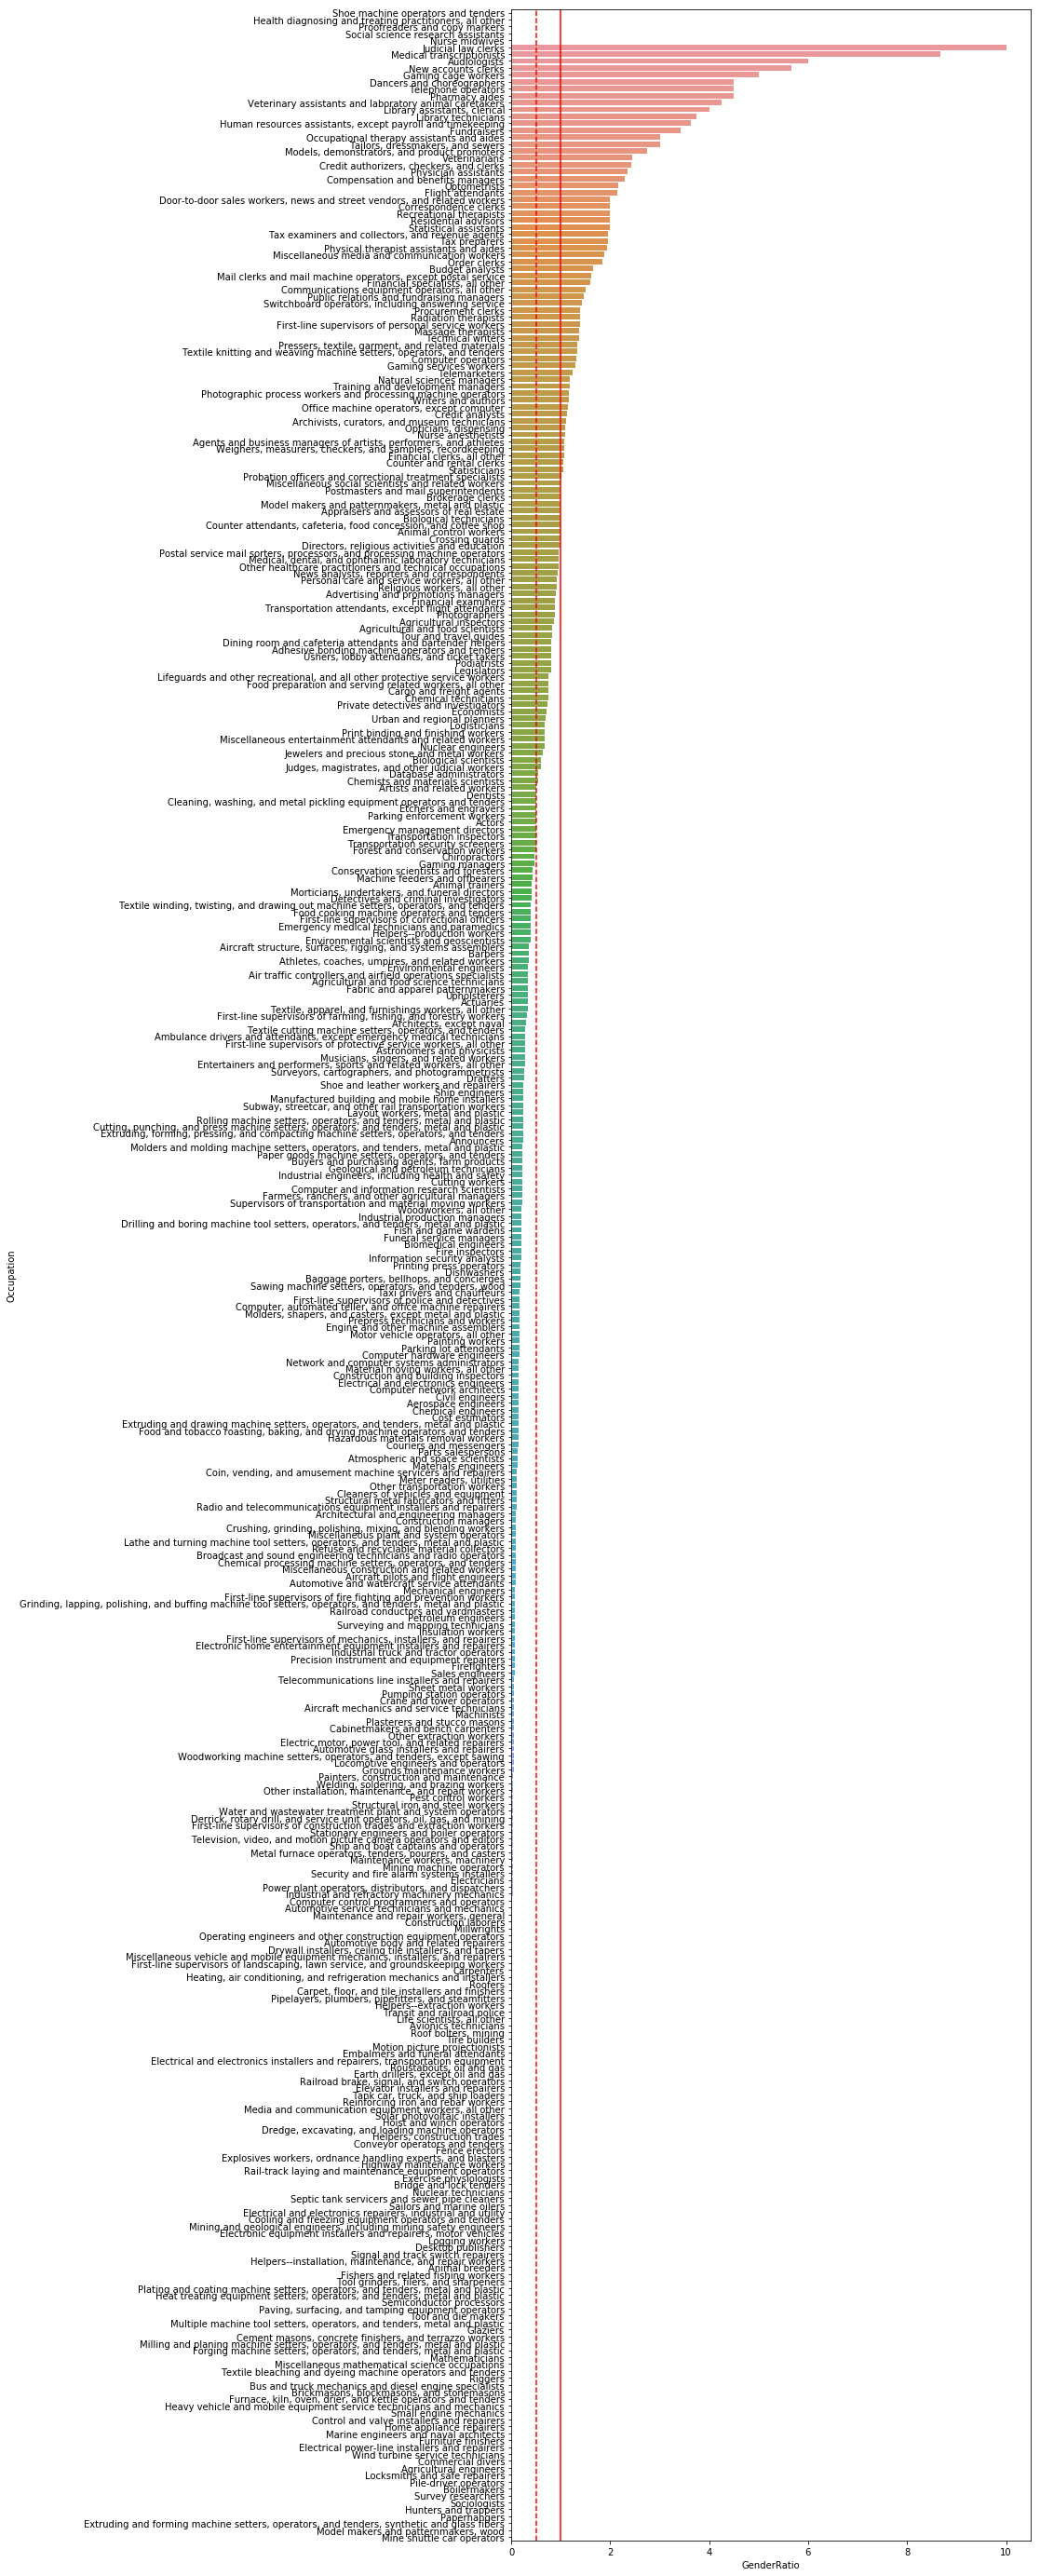

In [39]:
plt.figure(figsize=((10,50)))
sns.barplot(x='GenderRatio',
            y='Occupation',
            data=no_wage_df.sort_values('GenderRatio', ascending=False))
plt.axvline(x=1, color='red', linestyle='solid')
plt.axvline(x=.5, color='red', linestyle='--')

plt.show()
plt.show()

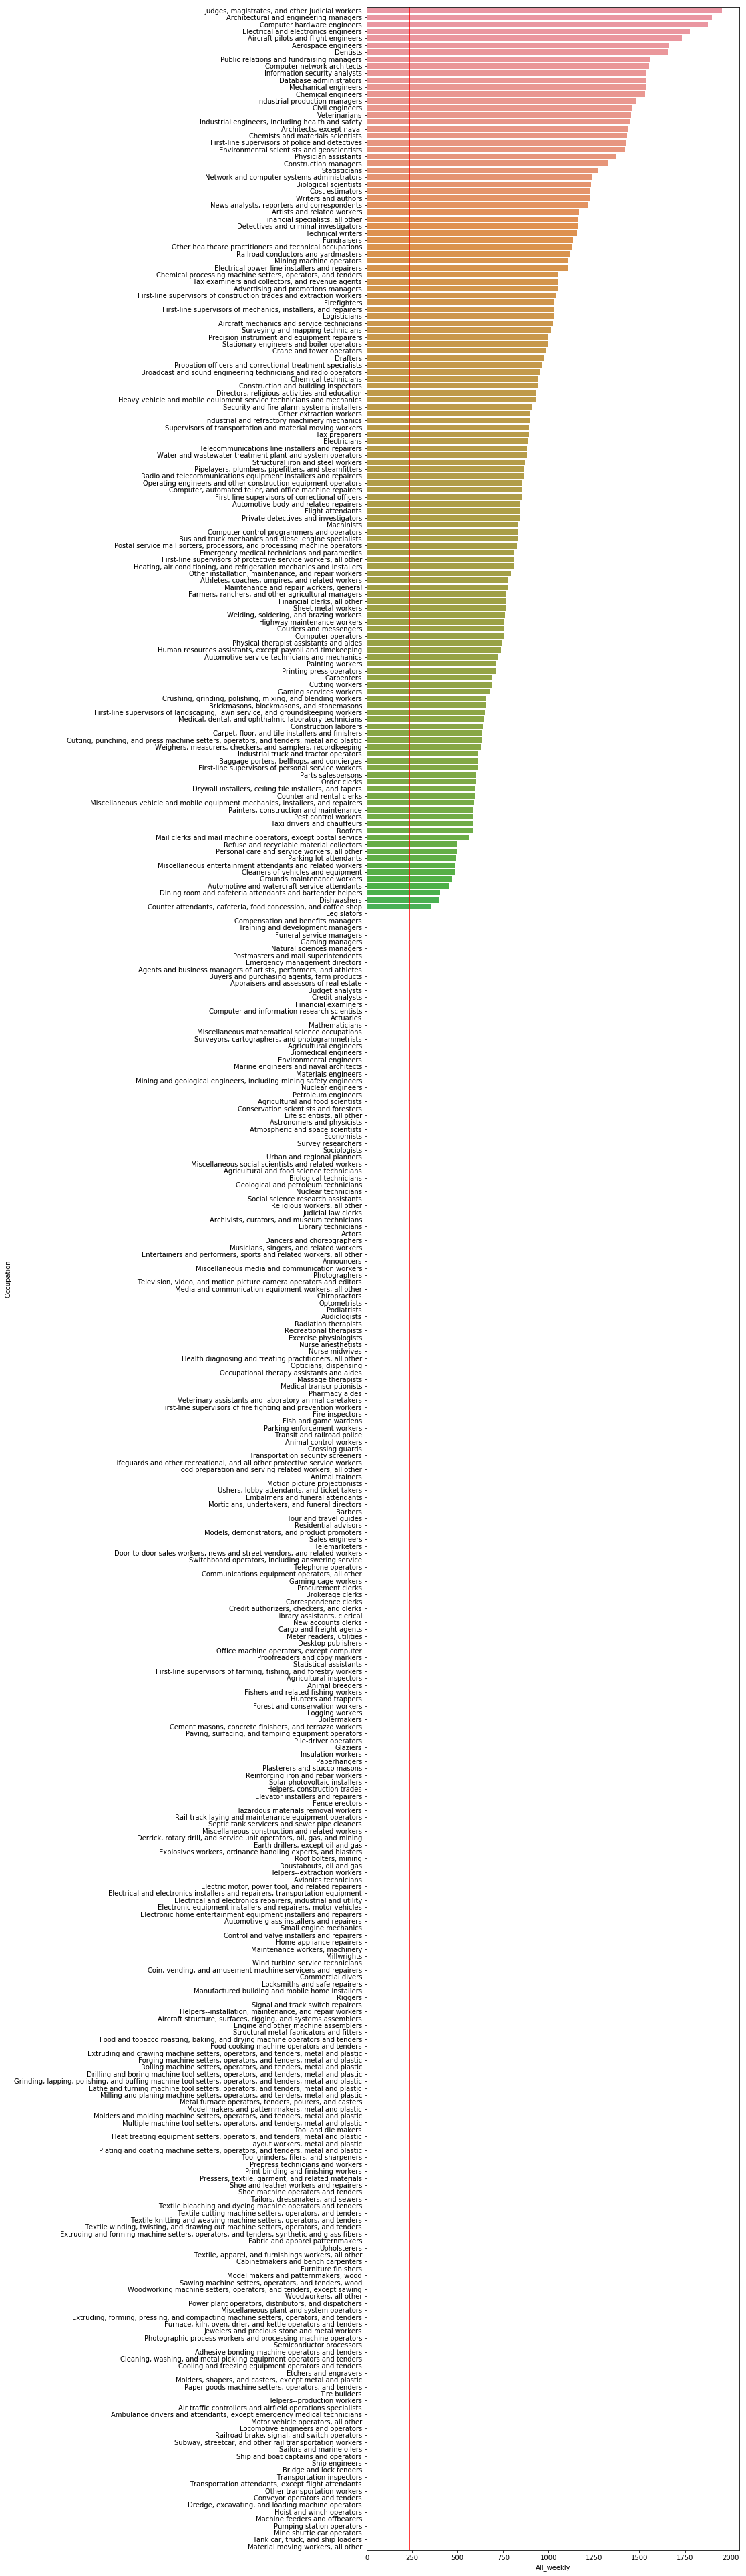

In [64]:
plt.figure(figsize=((10,70)))
sns.barplot(x='All_weekly',
            y='Occupation',
            data=no_wage_df.sort_values('All_weekly', ascending=False))
# HHS defines poverty as $12,140 per year for one person
# That roughly divides into $233 per week(not accounting for taxes)
# https://aspe.hhs.gov/poverty-guidelines
plt.axvline(x=233, color='red', linestyle='solid')
plt.show()

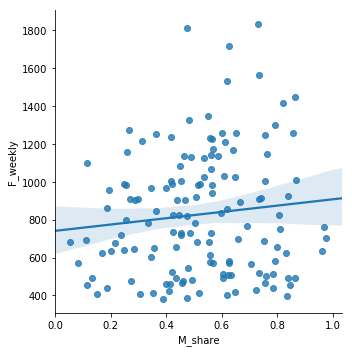

In [41]:
sns.lmplot(x='M_share', y='F_weekly', data=cleanedgenderwage)
plt.show()

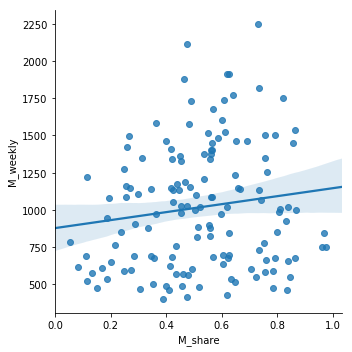

In [42]:
# lmplot of male wages vs male share
sns.lmplot(x='M_share', y='M_weekly', data=cleanedgenderwage)
plt.show()

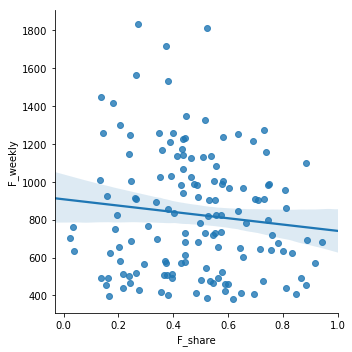

In [43]:
# lmplot of female wages vs female share
sns.lmplot(x='F_share', y='F_weekly', data=cleanedgenderwage)
plt.show() # looks like as women take over a field, it just pays less -.- 

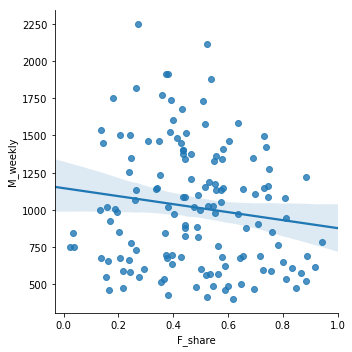

In [44]:
# lmplot of Male wages vs female share
sns.lmplot(x='F_share', y='M_weekly', data=cleanedgenderwage)
plt.show() 

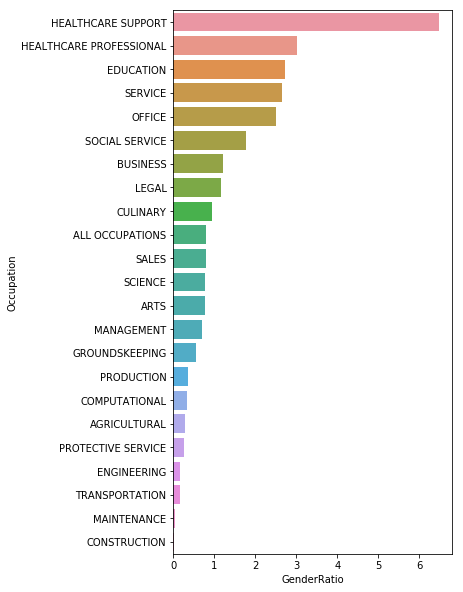

In [45]:
# Lets look at the gender ratio for just the occupational categories

plt.figure(figsize=((5,10)))
sns.barplot(x='GenderRatio',
            y='Occupation',
            data=categories_df.sort_values('GenderRatio', ascending=False))
plt.show()

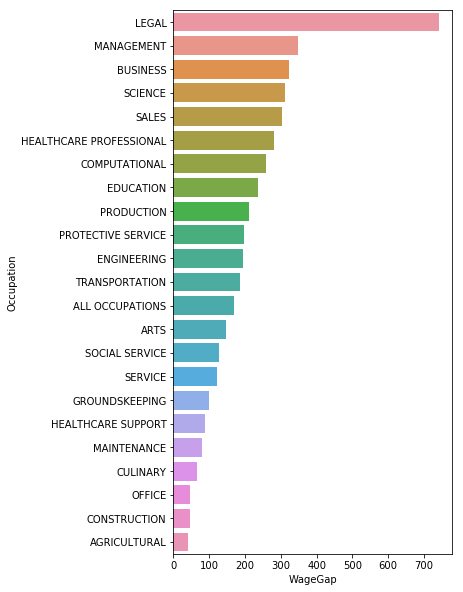

In [46]:
# Now lets see the wage gap
plt.figure(figsize=((5,10)))
sns.barplot(x='WageGap',
            y='Occupation',
            data=categories_df.sort_values('WageGap', ascending=False))
plt.show()

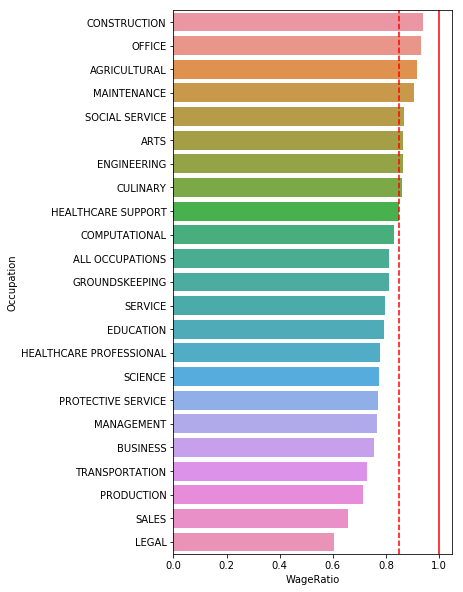

In [47]:
# Looking at wage ratios for men v women
# Red line indicates equal to mens wages, dashed line is 15% less 
plt.figure(figsize=((5,10)))
sns.barplot(x='WageRatio',
            y='Occupation',
            data=categories_df.sort_values('WageRatio', ascending=False))
plt.axvline(x=.85, color='red', linestyle='dashed')
plt.axvline(x=1, color='red', linestyle='solid')
plt.show()

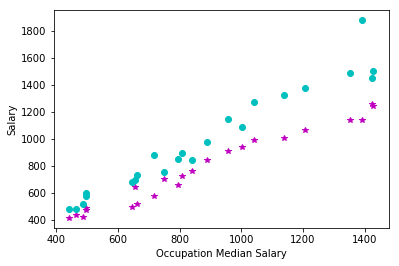

In [48]:
# Mens vs Womens salaries

plt.plot(categories_df['All_weekly'], categories_df['F_weekly'], '*', color='m')
plt.plot(categories_df['All_weekly'], categories_df['M_weekly'], 'o', color='c')
plt.xlabel('Occupation Median Salary')
plt.ylabel('Salary')
plt.show()

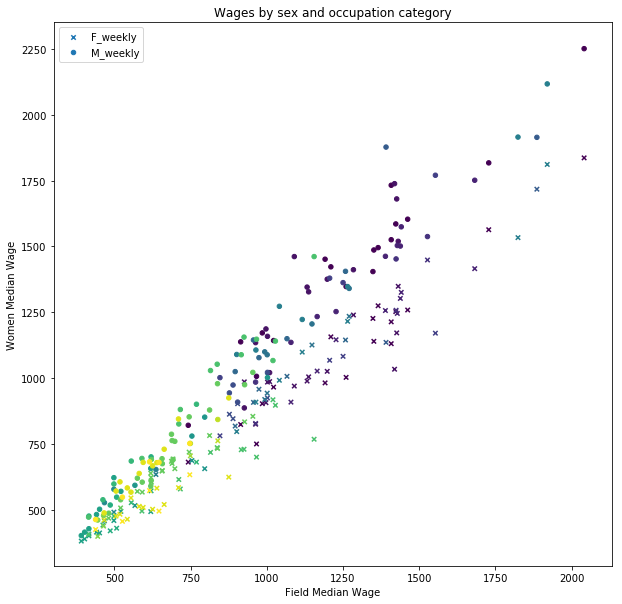

In [49]:
# plot wage by gender and color by occupation category
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.set_title("Wages by sex and occupation category")
ax.set_xlabel("Field Median Wage")
ax.set_ylabel("Women Median Wage")
x = cleanedgenderwage['All_weekly']
y = cleanedgenderwage['F_weekly']
y2 = cleanedgenderwage['M_weekly']
colors = [str(item) for item in cleanedgenderwage['Occupation_Category']]

ax.scatter(x,y,s=20,c=colors, marker = 'x');
ax.scatter(x,y2,s=20,c=colors, marker = 'o');
plt.legend()
plt.show()


# Time for some MODELS

we will be reviewing linear or logisitic regression classifier, then lasso regression classifier, then a random forest classifier

The questions I will be looking to answer today is:
    - Can you predict occupational category given wage, gender, gender ratio and share of females for that field? 
    
    what good is this really? what practicle use can this have?

In [50]:
# make new dfs here
F_df = pd.DataFrame()
M_df = pd.DataFrame()

# make category variable for gender
F_df['Wage'] = cleanedgenderwage['F_weekly']
M_df['Wage'] = cleanedgenderwage['M_weekly']

F_df['Gender'] = np.ones(len(cleanedgenderwage))
M_df['Gender'] = np.zeros(len(cleanedgenderwage))

F_df['F_share'] = cleanedgenderwage['F_share']
M_df['F_share'] = cleanedgenderwage['F_share']
F_df['GenderRatio'] = cleanedgenderwage['GenderRatio']
M_df['GenderRatio'] = cleanedgenderwage['GenderRatio']

F_df['Occupation_Category'] = cleanedgenderwage['Occupation_Category_label']
M_df['Occupation_Category'] = cleanedgenderwage['Occupation_Category_label']


F_df['Occupation_Median_wage'] = cleanedgenderwage['All_weekly']
M_df['Occupation_Median_wage'] = cleanedgenderwage['All_weekly']

combined_df = F_df.append(M_df)



In [51]:
# set up training and testing sets, fit model, score model
# need to split up dataset before oversampling



def model_testing(model, X_test, y_test, X_train, y_train):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    scored_model_train = model.score(X_train, y_train)
    scored_model_test = model.score(X_test, y_test)
    model_accuracy = accuracy_score(y_test, y_pred)
    print("Model Score with Training data:")
    print(scored_model_train)
    print("Model Score with Testing data:")
    print(scored_model_test)
    print("Accuracy Score")
    print(model_accuracy)
   

In [52]:
def sampled_set(data, sample_count):
    sampled = np.random.choice(a=data, size=sample_count)
    return(sampled)


In [53]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(k=3, ratio=1, kind='borderline1')

In [65]:
# scale columns here
scaler = StandardScaler()
columns = ['F_share','Gender','Wage','GenderRatio']
# split up data first, then resample only the training data, maybe try smote again

X = combined_df[columns]

X_std = StandardScaler().fit_transform(X)
y = combined_df['Occupation_Category']

X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=.35)


In [81]:
y.value_counts()

OFFICE                     36
MANAGEMENT                 34
BUSINESS                   26
PRODUCTION                 24
SALES                      24
HEALTHCARE PROFESSIONAL    20
CULINARY                   16
COMPUTATIONAL              16
SOCIAL SERVICE             12
TRANSPORTATION             10
EDUCATION                  10
SCIENCE                     8
PROTECTIVE SERVICE          8
SERVICE                     8
GROUNDSKEEPING              8
INFRASTRUCTURE SUPPORT      8
ARTS                        8
ENGINEERING                 6
Name: Occupation_Category, dtype: int64

In [ ]:
# set up x and y variables
#X = combined_df.drop(['Occupation_Category'], axis=1)
#y = combined_df['Occupation_Category']

In [ ]:
# Linear/logisitic Regression here
from sklearn.linear_model import LogisticRegression
logr = LogisticRegression()
model_testing(logr, X_std, y, .35)

In [ ]:
# Lasso Regression classifier here
lasso = linear_model.Lasso()
#model_testing(lasso, X_std, y, .35)

In [ ]:
# Ridge Regression classifier here
ridge = linear_model.RidgeClassifier()
model_testing(ridge, X_std, y, .35)

In [ ]:
# Random Forest Classifier here
forest = ensemble.RandomForestClassifier(n_estimators=300, max_depth=3)
model_testing(forest, X_std, y, .35)

In [ ]:
# SVM?
from sklearn.svm import SVC
svc = SVC()
model_testing(svc, X_std, y, .35)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier()
model_testing(dtree, X_std, y, .35)

In [ ]:
extree = ensemble.ExtraTreesClassifier()
model_testing(extree, X_std, y, .35)

In [ ]:
gradient = ensemble.GradientBoostingClassifier()
model_testing(dtree, X_std, y, .35)

The tpp three preliminary models were the decision tree classifier, the extra trees classifier and the gradient boosting classifier. 

Next we will use SKLearn's built in tool GrilSearch to find the best hyperparameters.

In [ ]:
# Put hyper parameter adjustment here
from sklearn.model_selection import GridSearchCV

extra_tree_param = {'criterion': ('gini', 'entropy'),
                    'max_depth': (2, 3, 5),
                    'n_estimators': (10, 50, 100)}
decision_tree_param = {'criterion': ('gini', 'entropy'),
                       'max_depth': (2, 3, 5)}
gradient_params = {'learning_rate': (.01, .25, .5, .75, 1),
                   'n_estimators':(100, 150, 200, 300),
                   'max_depth':(2, 3, 4, 5, 6)}

def check_grid(estimator, params):
    grid_classifier = GridSearchCV(estimator=estimator, param_grid=params)
    grid_classifier.fit(X_std, y)
    grid_score = grid_classifier.score(X_std, y)
    print(grid_score)

In [ ]:
check_grid(dtree, decision_tree_param)

In [ ]:
check_grid(extree, extra_tree_param)

In [ ]:
check_grid(gradient, gradient_params)

In [ ]:
# get params here for best model

In [ ]:
X_std.shape

In [ ]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(k=3, ratio=1, kind='borderline1')

In [ ]:
y_values = y.values
y_values.shape

In [ ]:
# Put model validation here

# Put conclusion here